In [6]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


# 1. Import Libraries

In [7]:
import json
import logging
import os.path
import time
import numpy as np
import pandas as pd
import cv2
import shutil
from matplotlib import pyplot as plt
from PIL import Image

# 2.Processing  metadata file with image metadata

In [8]:
start_time = time.time()

LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
logging.basicConfig(filename='./processing.log',
                    level = logging.DEBUG, 
                    format = LOG_FORMAT)
logger = logging.getLogger()
logging.getLogger('matplotlib.font_manager').disabled = True



In [9]:
try:
    config = open('./config.json')
    config = json.load(config)
    out_file = config['output_file']
    out_folder =config['output_folder']
    file_prefix = "input_images_source_"
    path_to_output = f'./{out_file}'
    files = os.listdir('.')
except FileNotFound:
    logger.error("Config file not found")
    raise
    
list_of_json = []
list_of_dicts =[]
list_of_filenames = []
list_width_to_height_ratio = []


out_path = f"./{out_folder}"

#Checks if output json file exists and if it does deletes it
if os.path.exists(path_to_output):
    os.remove(path_to_output)#deletes JSON
if os.path.exists(out_path):
    shutil.rmtree(out_path)# deletes output file

os.mkdir(out_path)

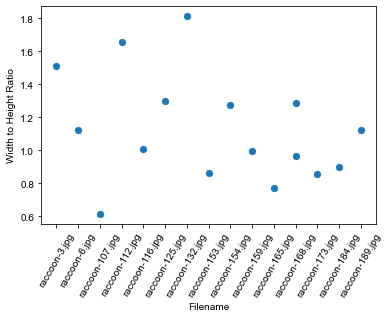

In [10]:
logger.info("Processing metadata file with image data.")

#Creates a list with  the content of all  image metadata JSON files
try:
    for file in files:
        if file_prefix in file:
            jpath = './'+ file
            data_file = os.listdir(jpath)
            for item in data_file:
                if item.endswith('.json'):
                    json_file = open(jpath + "/" + item)
                    data = json.load(json_file)
                    list_of_json.append(data)
except FileNotFound:
    logger.error("Image files not found")
    raise

#Loops through all Json files in the list and calculates the labels's width to height ration and label area percentage.
# Also extracts the rest of the data for the Output JSON
try:
    for item in list_of_json:
        for image in item['data']:
            if 'filename' in image.keys() and image['filename'].endswith('jpg') == False:
                image['filename'] = image['filename'] + '.jpg'
            if 'path' not in image.keys():
                path_to_image = image['folder'] +image['filename']
                filename = image['filename']
            else:
                path_to_image = image['path']
                filename = path_to_image.split('/')[-1]
            im_data = Image.open(path_to_image)
            if filename.endswith('.jpg') == False:
                pth_lst = path_to_image.split(".")
                pth_lst[-1] = '.jpg'
                pth = "".join(pth_lst)
                path_to_image = pth
                im_data.save(pth)
                filename = filename.replace(filename.split('.')[-1],'jpg')
            image_width, image_height = im_data.size
            image_area = image_width * image_height
            if 'label_width' not in image.keys() and 'label_height' not in image.keys():
                if  image['xmax'] > 1:
                    image['xmax'] = image['xmax'] / image_width
                    image['xmin'] =image['xmin'] / image_width
                    image['ymax'] =image['ymax'] / image_height
                    image['ymin'] =image['ymin'] / image_height
                    xmax,xmin,ymax,ymin = image['xmax'],image['xmin'],image['ymax'],image['ymin']
                else:
                    xmax, xmin, ymax, ymin = image['xmax'], image['xmin'], image['ymax'], image['ymin']
                label_width = (xmax - xmin) * image_width
                label_height = (ymax - ymin) * image_height
            else:
                label_width = image['label_width']
                label_height =image ['label_height']
            label_area = label_height * label_width
            width_to_height =round(label_width / label_height,3)
            label_area_perc = round(label_area / image_area,1)
            if 'xmax' in image.keys():
                xmax, xmin, ymax, ymin = image['xmax'], image['xmin'], image['ymax'], image['ymin']
            else:
                xmax = (image['label_horz_center'] + (label_width/2))/image_width
                xmin = (image['label_horz_center'] - (label_width / 2))/image_width
                ymax = (image['label_vert_center'] + (label_height / 2))/image_height
                ymin = (image['label_vert_center']  - (label_height / 2))/image_height
            list_of_filenames.append(filename)
            list_width_to_height_ratio.append(width_to_height)
            label_type = filename.split('-')[0].capitalize() 
            dictionary = {
     "path": path_to_image,
     "filename": filename,
     "image_height": image_height,
     "image_width": image_width,
     "label_area_perc": label_area_perc,
     "labels": [
     {
     "xmin": round(xmin,1),
     "ymin": round(ymin,1),
     "xmax": round(xmax,2),
     "ymax": round(ymax,2),
     "label": label_type,
     "width_to_height": width_to_height
     }]}
            list_of_dicts.append(dictionary)

    output = {'data': list_of_dicts}
    output_json = json.dumps(output,indent=4)

    with open (out_file,'w') as outfile:
        outfile.write(output_json)
except RuntimeError:
    logger.error("Error while compiling metadata")
    raise    
logger.info("Finished processing metadata file with image data.")
logger.info("Ploting width to height ratios")

try:
    plt.xticks(rotation =60)
    plt.xlabel('Filename')
    plt.ylabel('Width to Height Ratio')
    plt.style.use('seaborn')
    plt.scatter(list_of_filenames,list_width_to_height_ratio)
except RuntimeError:
    logger.error("Error ploting width to height ratios")
    raise

logger.info("Finished ploting width to height ratios")



# 3.  Processes images

In [11]:
max_width = config['max_width']
max_height = config['max_height']
overlap = config['overlap']
window_overlap_horiz = overlap * max_width
window_overlap_vert = overlap * max_height

img_data = open (out_file)
img_data = json.load(img_data)



# 3.1 Croping, resizing and Sliding Window

In [14]:
logger.info("Croping and resizing images")
try:
    for image in img_data['data']:
        img_labels = image['labels'][0]
        img = cv2.imread(image['path'])
        img = img[int(img_labels['ymin']*image['image_height']):int(img_labels['ymax']*image['image_height']),int(img_labels['xmin']*image['image_width']):int(img_labels['xmax']*image['image_width'])]
        img = cv2.resize(img,(max_width,max_height))
        cv2.imwrite(os.path.join(out_path, image['filename']), img)
        #Sliding Window
        for y in np.arange(0,int(img_labels['ymax']*image['image_height']),window_overlap_vert):
            for x in np.arange(0,int(img_labels['xmax']*image['image_width']),window_overlap_horiz):
                img_clone = cv2.imread(os.path.join(out_path, image['filename']))
                x_border = x + (max_width/2)
                y_border =y + (max_height/2)
                cv2.rectangle(img,(int(x),int(y)),(int(x_border),int(y_border)),(0,0,255),5)
                cv2.imshow(image['filename'],img)
                img = img_clone
                cv2.waitKey(50)
                if x_border >= max_width:
                    break
            if y_border >= max_height:
                cv2.destroyAllWindows()
                break
except RuntimeError :
    logger.error("Error croping and resizing images")
    raise
            
logger.info("Finished Croping and resizing images")
logger.info(f"Program Done : Took {time.time() - start_time} seconds")
print("Finished: Program took: ""--- %s seconds ---" % (time.time() - start_time))
    

Finished: Program took: --- 240.32680249214172 seconds ---
